In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
reviews = pd.read_csv('Books_rating.csv')

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


## Step 1: Data Cleaning - remove important NaN rows and check for duplicates

In [5]:
# The rows with missing values in the reviews field and the title field can be dropped because we'll need these 
# for the analysis.
reviews.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561886
review/helpfulness          0
review/score                0
review/time                 0
review/summary             38
review/text                 8
dtype: int64

In [6]:
# Drop those NaN columns
reviews = reviews.dropna(subset=['Title', 'review/text'])

In [7]:
reviews.Id.nunique()

221989

In [8]:
# Check for Duplicates
reviews.duplicated(keep="first").sum()

8774

In [9]:
# Looks like there are some duplicates so we can drop those
reviews.drop_duplicates(keep="first",inplace=True)

In [10]:
reviews.duplicated(keep="first").sum()

0

In [11]:
# reset our index
reviews.reset_index(inplace=True)

## Step 2:  Define my classes and target

In [12]:
reviews['review/score'].value_counts()

5.0    1801247
4.0     583653
3.0     253771
1.0     201468
2.0     150871
Name: review/score, dtype: int64

<AxesSubplot:>

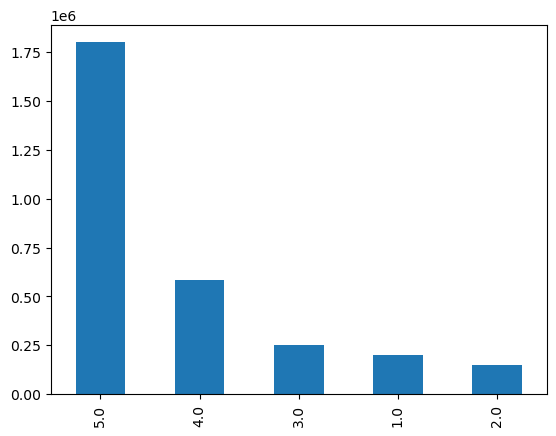

In [13]:
# First I'm going to check the distribution of scores in my data 

reviews['review/score'].value_counts().plot(kind='bar')

In [14]:
# The reviews are heavily weighted in 5 - I'll need to consider this when taking my sample
# I'm going to drop all the 3's and focus on classifying my 1's and 2's to negative (0) and my 
# 4's and 5's to positive (1)

In [15]:
# Drops the 3's
reviews.drop(reviews[reviews['review/score'] == 3.0].index, inplace = True)

In [16]:
# Change the other values to my classifications

reviews['review/score'].replace([1.0, 2.0, 4.0, 5.0],[0, 0, 1, 1], inplace=True)

## Step 3:  With such a big dataset, take a smaller sample to train the model on

In [17]:
# I'm going to choose a sample of 100,000 rows but I want to have evenly distributed 1's and 0's so I can 
# train my model better
sample_size = 50000
sample_df = pd.DataFrame()
for i in reviews['review/score'].unique():
  X = reviews[reviews['review/score'] == i].sample(sample_size)
  sample_df = sample_df.append(X)

C:\Users\liisa\AppData\Local\Temp\ipykernel_6988\3658997412.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(X)
C:\Users\liisa\AppData\Local\Temp\ipykernel_6988\3658997412.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(X)


In [18]:
sample_df['review/score'].value_counts()

1.0    50000
0.0    50000
Name: review/score, dtype: int64

In [19]:
reviews = reviews.drop(sample_df.index)

In [20]:
#check if it worked and then resave our files
sample_df.info()
reviews.info()


sample_df.to_csv("sample.csv", index=False)
reviews.to_csv("reviews.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 955449 to 1443400
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               100000 non-null  int64  
 1   Id                  100000 non-null  object 
 2   Title               100000 non-null  object 
 3   Price               16257 non-null   float64
 4   User_id             79297 non-null   object 
 5   profileName         79295 non-null   object 
 6   review/helpfulness  100000 non-null  object 
 7   review/score        100000 non-null  float64
 8   review/time         100000 non-null  int64  
 9   review/summary      99997 non-null   object 
 10  review/text         100000 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637239 entries, 0 to 2991008
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              

## Step 4: Start preprocessing my sample dataset

In [41]:
# Import the libraries I'll need for the preprocessing and my model 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn


In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liisa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# Start the pre-processing that I'll do outside of my model 

# Use NLTK library to tokenize (split sentences into words) and change to lowercase

sample_df['tokenized_text'] = sample_df['review/text'].apply(word_tokenize) 

In [27]:
sample_df['tokenized_text'] = sample_df['review/text'].apply(str.lower)

In [34]:
sample_df['tokenized_text'] = sample_df['tokenized_text'].apply(word_tokenize) 

In [35]:
sample_df.head()

,index,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,tokenized_text
955449,958551,1576752070,Sprout!: Everything I Need to Know about Sales...,15.56,A2L1SGWA2CPG0P,Rosalind,0/0,1.0,1078099200,Sprout your business!,I read Sprout! in a couple of hours. Once I st...,"[i, read, sprout, !, in, a, couple, of, hours,..."
91635,91865,0673995275,The American People: Creating a Nation and a S...,NaN,NaN,NaN,14/20,1.0,1065484800,"Finally, a balanced history text",Some of the reviews posted here are just bizar...,"[some, of, the, reviews, posted, here, are, ju..."
2435415,2442991,B000OV5U1Y,Lindbergh: A Biography,NaN,A1UNMDPC9U3F4B,denny j Huber,0/13,1.0,981590400,"Indeed,God is my Co-Pilot....","This bio has merit,to be supplemented by many ...","[this, bio, has, merit, ,, to, be, supplemente..."
1173797,1177604,1401302548,"Myths, Lies, and Downright Stupidity: Get Out ...",11.91,AL4ELPBWZA1BO,Jack E. Vannoord,21/47,1.0,1147910400,"The Truth, The Whole Truth and Nothing but the...","Yes, he's glib. He writes in the same sound-bi...","[yes, ,, he, 's, glib, ., he, writes, in, the,..."
2259366,2266402,0006547001,Empire of the Sun,NaN,A2ZTQ269EBVWPC,geoffrey.vasil@flf.vu.lt,1/1,1.0,883440000,Why does some wierd guy in Shepperton speak Ja...,Because he grew up as a war orphan in a Japane...,"[because, he, grew, up, as, a, war, orphan, in..."


In [37]:
# I'll work on the stop words now.  
# First I'll add "book" to the stop words list because it won't add much to the analysis
english_stopwords = stopwords.words('english')
english_stopwords.extend(['book', 'books'])
#Then I'll remove 'but' and 'not' from the list because these might be helpful
english_stopwords.remove('not')
english_stopwords.remove('but')


In [39]:
sample_df['tokenized_text'] = sample_df['tokenized_text'].apply(lambda x: [item for item in x if item not in english_stopwords])

In [40]:
sample_df.head()

,index,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,tokenized_text
955449,958551,1576752070,Sprout!: Everything I Need to Know about Sales...,15.56,A2L1SGWA2CPG0P,Rosalind,0/0,1.0,1078099200,Sprout your business!,I read Sprout! in a couple of hours. Once I st...,"[read, sprout, !, couple, hours, ., started, c..."
91635,91865,0673995275,The American People: Creating a Nation and a S...,NaN,NaN,NaN,14/20,1.0,1065484800,"Finally, a balanced history text",Some of the reviews posted here are just bizar...,"[reviews, posted, bizarre, -, read, ?, yes, ,,..."
2435415,2442991,B000OV5U1Y,Lindbergh: A Biography,NaN,A1UNMDPC9U3F4B,denny j Huber,0/13,1.0,981590400,"Indeed,God is my Co-Pilot....","This bio has merit,to be supplemented by many ...","[bio, merit, ,, supplemented, many, auto-biogr..."
1173797,1177604,1401302548,"Myths, Lies, and Downright Stupidity: Get Out ...",11.91,AL4ELPBWZA1BO,Jack E. Vannoord,21/47,1.0,1147910400,"The Truth, The Whole Truth and Nothing but the...","Yes, he's glib. He writes in the same sound-bi...","[yes, ,, 's, glib, ., writes, sound-bite, styl..."
2259366,2266402,0006547001,Empire of the Sun,NaN,A2ZTQ269EBVWPC,geoffrey.vasil@flf.vu.lt,1/1,1.0,883440000,Why does some wierd guy in Shepperton speak Ja...,Because he grew up as a war orphan in a Japane...,"[grew, war, orphan, japanese, internment, camp..."


In [ ]:
# Next up is lemmatizing the text - replacing words with their root words (e.g., played, plays, playing 
# will all be changed to play)

In [49]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text] 


In [45]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liisa\AppData\Roaming\nltk_data...


True

In [47]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liisa\AppData\Roaming\nltk_data...


True

In [53]:
sample_df.loc[sample_df.index == 955449]

,index,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,tokenized_text
955449,958551,1576752070,Sprout!: Everything I Need to Know about Sales...,15.56,A2L1SGWA2CPG0P,Rosalind,0/0,1.0,1078099200,Sprout your business!,I read Sprout! in a couple of hours. Once I st...,"[read, sprout, !, couple, hours, ., started, c..."


In [50]:
sample_df['tokenized_text'].apply(lemmatize_text)

955449     [read, sprout, !, couple, hour, ., started, co...
91635      [review, posted, bizarre, -, read, ?, yes, ,, ...
2435415    [bio, merit, ,, supplemented, many, auto-biogr...
1173797    [yes, ,, 's, glib, ., writes, sound-bite, styl...
2259366    [grew, war, orphan, japanese, internment, camp...
                                 ...                        
365057     [maybe, 40, 50, interesting, page, ..., 70, li...
1728696    [true, disappointment, ., series, (, sutter, ,...
198577     [weather, maker, :, man, changing, climate, me...
2471380    [read, many, johanna, lindsey, 's, romance, di...
1443400    [kant, stated, discovery, hume, awoke, dogmati...
Name: tokenized_text, Length: 100000, dtype: object

In [59]:
def get_wn_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

  return tag_dict.get(tag, wn.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()

def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wn_pos(w)) for w in nltk.word_tokenize(sent)])

In [56]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liisa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [60]:
sample_df['cleaned'] =sample_df['tokenized_text'].apply(' '.join)
sample_df['review_cleaned_lemmatized'] = sample_df['cleaned'].apply(get_lemmatize)

In [61]:
sample_df.head()

,index,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,tokenized_text,cleaned,review_cleaned_lemmatized
955449,958551,1576752070,Sprout!: Everything I Need to Know about Sales...,15.56,A2L1SGWA2CPG0P,Rosalind,0/0,1.0,1078099200,Sprout your business!,I read Sprout! in a couple of hours. Once I st...,"[read, sprout, !, couple, hours, ., started, c...",read sprout ! couple hours . started could n't...,read sprout ! couple hour . start could n't pu...
91635,91865,0673995275,The American People: Creating a Nation and a S...,NaN,NaN,NaN,14/20,1.0,1065484800,"Finally, a balanced history text",Some of the reviews posted here are just bizar...,"[reviews, posted, bizarre, -, read, ?, yes, ,,...","reviews posted bizarre - read ? yes , writes m...","review post bizarre - read ? yes , writes mino..."
2435415,2442991,B000OV5U1Y,Lindbergh: A Biography,NaN,A1UNMDPC9U3F4B,denny j Huber,0/13,1.0,981590400,"Indeed,God is my Co-Pilot....","This bio has merit,to be supplemented by many ...","[bio, merit, ,, supplemented, many, auto-biogr...","bio merit , supplemented many auto-biographica...","bio merit , supplement many auto-biographical ..."
1173797,1177604,1401302548,"Myths, Lies, and Downright Stupidity: Get Out ...",11.91,AL4ELPBWZA1BO,Jack E. Vannoord,21/47,1.0,1147910400,"The Truth, The Whole Truth and Nothing but the...","Yes, he's glib. He writes in the same sound-bi...","[yes, ,, 's, glib, ., writes, sound-bite, styl...","yes , 's glib . writes sound-bite style uses 2...","yes , 's glib . writes sound-bite style us 20/..."
2259366,2266402,0006547001,Empire of the Sun,NaN,A2ZTQ269EBVWPC,geoffrey.vasil@flf.vu.lt,1/1,1.0,883440000,Why does some wierd guy in Shepperton speak Ja...,Because he grew up as a war orphan in a Japane...,"[grew, war, orphan, japanese, internment, camp...",grew war orphan japanese internment camp china...,grow war orphan japanese internment camp china...


In [63]:
# Remove the punctuation and then continue with the more advanced preprocessing
sample_df['review_cleaned_lemmatized'] = sample_df['review_cleaned_lemmatized'].str.replace(r'[^\w\s]+', '')

C:\Users\liisa\AppData\Local\Temp\ipykernel_6988\1912873563.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  sample_df['review_cleaned_lemmatized'] = sample_df['review_cleaned_lemmatized'].str.replace(r'[^\w\s]+', '')


In [65]:
# I will remove the numbers too because they don't be much help in text analysis

sample_df['review_cleaned_lemmatized'] = sample_df['review_cleaned_lemmatized'].str.replace('\d+', '')

C:\Users\liisa\AppData\Local\Temp\ipykernel_6988\2156378743.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  sample_df['review_cleaned_lemmatized'] = sample_df['review_cleaned_lemmatized'].str.replace('\d+', '')


In [66]:
sample_df.head()

,index,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,tokenized_text,cleaned,review_cleaned_lemmatized
955449,958551,1576752070,Sprout!: Everything I Need to Know about Sales...,15.56,A2L1SGWA2CPG0P,Rosalind,0/0,1.0,1078099200,Sprout your business!,I read Sprout! in a couple of hours. Once I st...,"[read, sprout, !, couple, hours, ., started, c...",read sprout ! couple hours . started could n't...,read sprout couple hour start could nt put ...
91635,91865,0673995275,The American People: Creating a Nation and a S...,NaN,NaN,NaN,14/20,1.0,1065484800,"Finally, a balanced history text",Some of the reviews posted here are just bizar...,"[reviews, posted, bizarre, -, read, ?, yes, ,,...","reviews posted bizarre - read ? yes , writes m...",review post bizarre read yes writes minorit...
2435415,2442991,B000OV5U1Y,Lindbergh: A Biography,NaN,A1UNMDPC9U3F4B,denny j Huber,0/13,1.0,981590400,"Indeed,God is my Co-Pilot....","This bio has merit,to be supplemented by many ...","[bio, merit, ,, supplemented, many, auto-biogr...","bio merit , supplemented many auto-biographica...",bio merit supplement many autobiographical wr...
1173797,1177604,1401302548,"Myths, Lies, and Downright Stupidity: Get Out ...",11.91,AL4ELPBWZA1BO,Jack E. Vannoord,21/47,1.0,1147910400,"The Truth, The Whole Truth and Nothing but the...","Yes, he's glib. He writes in the same sound-bi...","[yes, ,, 's, glib, ., writes, sound-bite, styl...","yes , 's glib . writes sound-bite style uses 2...",yes s glib writes soundbite style us speica...
2259366,2266402,0006547001,Empire of the Sun,NaN,A2ZTQ269EBVWPC,geoffrey.vasil@flf.vu.lt,1/1,1.0,883440000,Why does some wierd guy in Shepperton speak Ja...,Because he grew up as a war orphan in a Japane...,"[grew, war, orphan, japanese, internment, camp...",grew war orphan japanese internment camp china...,grow war orphan japanese internment camp china...


In [22]:
sample_df.isna().sum()

index                            0
Id                               0
Title                            0
Price                        83743
User_id                      20703
profileName                  20705
review/helpfulness               0
review/score                     0
review/time                      0
review/summary                   3
review/text                      0
tokenized_text                   0
cleaned                          1
review_cleaned_lemmatized        1
dtype: int64

In [24]:
sample_df = sample_df.dropna(subset=['review_cleaned_lemmatized'])

In [68]:
sample_df.to_csv("sample.csv", index=False)

## Step 5:  Choose my target metric - Accuracy

## Step 6:  Train test split

In [26]:
X = sample_df['review_cleaned_lemmatized']
y = sample_df['review/score']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size = .3)

## Step 5:  More advanced preprocessing

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

In [5]:
# Do the cross-validation on the models by importing them
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [6]:
from sklearn.pipeline import make_pipeline

clf = LogisticRegression(max_iter=500)
count_vect = CountVectorizer(ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

pipe = make_pipeline(count_vect, tfidf_transformer, clf)

In [10]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('tfidftransformer', TfidfTransformer()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [11]:
pipe.score(X_train,y_train)

0.9414714285714286

## Day 2 - Continue to look at other models  - NaiveBayes and XGBoost

In [1]:
sample_df = pd.read_csv('sample.csv')

NameError: name 'pd' is not defined

In [27]:
## Train the model on Multinomial Bayes, which gives pretty good results

from sklearn.pipeline import make_pipeline

clf = MultinomialNB()
count_vect = CountVectorizer(ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

pipe = make_pipeline(count_vect, tfidf_transformer, clf)

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [29]:
pipe.score(X_train, y_train)

0.9774139630566151

In [30]:
pipe

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

## Below are the NBayes test scores

In [31]:
pipe.score(X_test, y_test)

0.8740666666666667

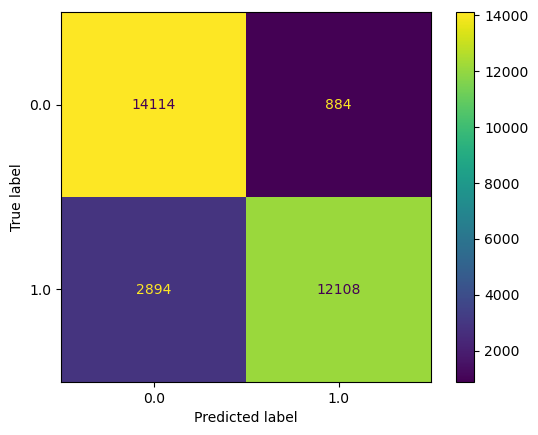

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)


## XGBoost Scores (without hyperparameters)

In [10]:
## Try XGBoost also for comparison
import xgboost as xgb
from xgboost import XGBClassifier

In [11]:
clf = XGBClassifier()
count_vect = CountVectorizer(ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

pipe = make_pipeline(count_vect, tfidf_transformer, clf)


In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('tfidftransformer', TfidfTransformer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=Non...e,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=n

In [20]:
pipe.score(X_train, y_train)

0.8914714285714286

## Step 6:  XGBoost has a lot of hyperparamters but because Bayes score so well on the test, we'll tune that a bit and try to tweak the results

In [13]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid_nb = {'multinomialnb__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

clf = MultinomialNB()
count_vect = CountVectorizer(ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

pipe = make_pipeline(count_vect, tfidf_transformer, clf)


grid_nb = GridSearchCV(estimator=pipe, param_grid=param_grid_nb, cv=5, scoring='accuracy')

grid_nb.fit(X_train, y_train)

print('Best score:', grid_nb.best_score_)
print('Best parameter:', grid_nb.best_params_)

Best score: 0.8725142857142858
Best parameter: {'multinomialnb__alpha': 0.1}


## Day 3:  Logistic Regression Hyperparameters (still on training data)

In [30]:
param_grid_logreg = {
    'logisticregression__C': [0.1, 1, 10, 100, 1000]
    } 
clf = LogisticRegression(max_iter=1000)
pipe = make_pipeline(count_vect, tfidf_transformer, clf)

grid_logreg = GridSearchCV(estimator=pipe, param_grid=param_grid_logreg, cv=5, scoring='accuracy')

grid_logreg.fit(X_train, y_train)

print('Best score:', grid_logreg.best_score_)
print('Best parameter:', grid_logreg.best_params_)

Best score: 0.8944142857142857
Best parameter: {'logisticregression__C': 1000}


## One more attempt to run the xg boost with hyperparameters
- did not work, XGBoost took too much CPU to run

In [34]:
## The below never ran fully, it is likely too man parameters

param_grid_xgb = {
    "xgbclassifier__max_depth": [3, 4, 5, 7],
    "xgbclassifier__learning_rate": [0.1, 0.01, 0.05],
    "xgbclassifier__gamma": [0, 0.25, 1],
    "xgbclassifier__reg_lambda": [0, 1, 10],
    "xgbclassifier__scale_pos_weight": [1, 3, 5],
    "xgbclassifier__subsample": [0.8],
    "xgbclassifier__colsample_bytree": [0.5]
}

clf = XGBClassifier()

pipe = make_pipeline(count_vect, tfidf_transformer, clf)

grid_xgb = GridSearchCV(estimator=pipe, param_grid=param_grid_xgb, cv=3, scoring='accuracy')

grid_xgb.fit(X_train, y_train)

print('Best score:', grid_xgb.best_score_)
print('Best parameter:', grid_xgb.best_params_)

KeyboardInterrupt: 